In [1]:
# ==============================
# Distributed Goodness-of-Fit Testing
# Under Communication Constraints
# ==============================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import chisquare
from tqdm import tqdm  # for progress bars

np.random.seed(42)


In [2]:
# Number of local devices / nodes
num_nodes = 10

# Number of categories (discrete support size)
num_categories = 20

# Total samples per node
samples_per_node = 500

# Communication budget (fraction of categories each node can send)
communication_fracs = [1.0, 0.5, 0.25, 0.1, 0.05]  # full to highly constrained


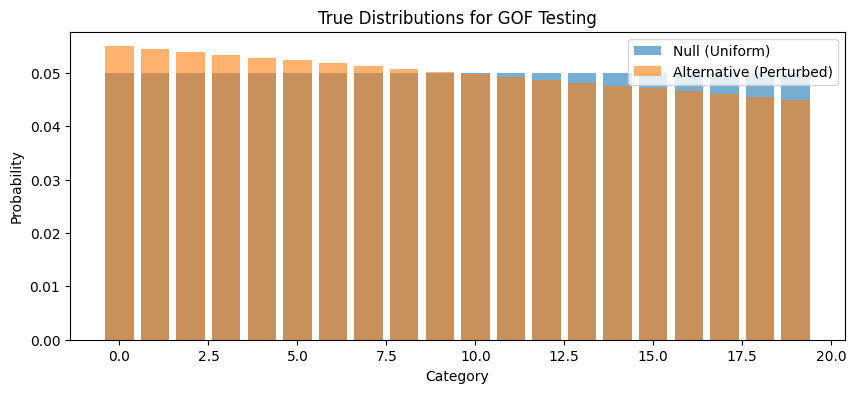

In [3]:
# Null: uniform over categories
p_null = np.ones(num_categories) / num_categories

# Alternative: slight bias toward first few categories
perturbation = np.linspace(0.05, -0.05, num_categories)
p_alt = p_null + perturbation / np.sum(perturbation > 0)  # renormalize
p_alt = np.clip(p_alt, 0, None)
p_alt = p_alt / np.sum(p_alt)

# Visualize distributions
plt.figure(figsize=(10,4))
plt.bar(np.arange(num_categories), p_null, alpha=0.6, label='Null (Uniform)')
plt.bar(np.arange(num_categories), p_alt, alpha=0.6, label='Alternative (Perturbed)')
plt.title("True Distributions for GOF Testing")
plt.xlabel("Category")
plt.ylabel("Probability")
plt.legend()
plt.show()


In [4]:
def generate_local_data(num_nodes, samples_per_node, distribution):
    """Generate data for each node under given distribution."""
    return [
        np.random.choice(np.arange(len(distribution)),
                         size=samples_per_node,
                         p=distribution)
        for _ in range(num_nodes)
    ]


In [5]:
local_data_H0 = generate_local_data(num_nodes, samples_per_node, p_null)
local_data_H1 = generate_local_data(num_nodes, samples_per_node, p_alt)


In [6]:
def communicate_limited_histogram(local_samples, num_categories, frac=1.0):
    """Simulate limited communication by sending partial histogram."""
    k = int(frac * num_categories)
    chosen_indices = np.random.choice(num_categories, k, replace=False)

    # Local histogram
    hist = np.bincount(local_samples, minlength=num_categories)
    # Send only the selected categories
    partial_hist = np.zeros(num_categories)
    partial_hist[chosen_indices] = hist[chosen_indices]

    return partial_hist


In [7]:
def distributed_gof_test(local_data, true_probs, frac):
    """Aggregate communicated histograms and perform chi-square test."""
    num_categories = len(true_probs)
    combined_hist = np.zeros(num_categories)

    for node_data in local_data:
        msg = communicate_limited_histogram(node_data, num_categories, frac)
        combined_hist += msg

    # Expected counts under H0
    expected = np.sum(combined_hist) * true_probs

    # Perform chi-square test
    chi2, p_value = chisquare(f_obs=combined_hist, f_exp=expected)
    return p_value


In [8]:
n_trials = 200
results = []

for frac in communication_fracs:
    print(f"Running communication fraction {frac}")
    pvals_H0 = []
    pvals_H1 = []

    for _ in tqdm(range(n_trials)):
        local_H0 = generate_local_data(num_nodes, samples_per_node, p_null)
        local_H1 = generate_local_data(num_nodes, samples_per_node, p_alt)

        pvals_H0.append(distributed_gof_test(local_H0, p_null, frac))
        pvals_H1.append(distributed_gof_test(local_H1, p_null, frac))

    # Compute rejection rates
    alpha = 0.05
    type1 = np.mean(np.array(pvals_H0) < alpha)
    power = np.mean(np.array(pvals_H1) < alpha)

    results.append({"Communication_Fraction": frac, "Type1_Error": type1, "Power": power})

df_results = pd.DataFrame(results)


Running communication fraction 1.0


100%|██████████| 200/200 [00:01<00:00, 174.24it/s]


Running communication fraction 0.5


100%|██████████| 200/200 [00:00<00:00, 351.72it/s]


Running communication fraction 0.25


100%|██████████| 200/200 [00:00<00:00, 342.45it/s]


Running communication fraction 0.1


100%|██████████| 200/200 [00:00<00:00, 347.82it/s]


Running communication fraction 0.05


100%|██████████| 200/200 [00:00<00:00, 309.71it/s]


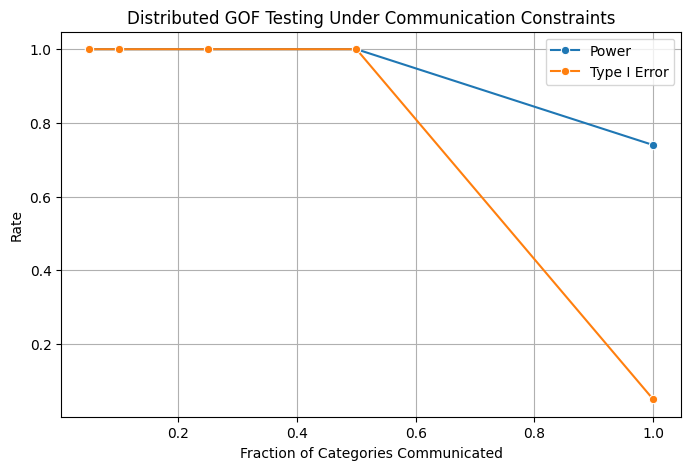

   Communication_Fraction  Type1_Error  Power
0                    1.00         0.05   0.74
1                    0.50         1.00   1.00
2                    0.25         1.00   1.00
3                    0.10         1.00   1.00
4                    0.05         1.00   1.00


In [9]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df_results, x="Communication_Fraction", y="Power", marker="o", label="Power")
sns.lineplot(data=df_results, x="Communication_Fraction", y="Type1_Error", marker="o", label="Type I Error")
plt.title("Distributed GOF Testing Under Communication Constraints")
plt.xlabel("Fraction of Categories Communicated")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.show()

print(df_results.round(3))


In [10]:
df_results.to_csv("distributed_gof_results.csv", index=False)
